# Ataque cardíaco

Análise e predição de ataques cardíacos.

In [264]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

## Data understanding

Os [dados utilizados](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)
nesse trabalho correspondem a um `.csv` de 303 linhas com as seguintes colunas:

- `Age`: Idade do paciente
- `Sex`: Sexo do paciente
- `exang`: angina indusida por exercício (1 = sim; 0 = não)
- `ca`: número de grande vazos sanguíneos (0-3)
- `cp`: tipo de dor no peito
  - Valor `1`: angina típica
  - Valor `2`: angina atípica
  - Valor `3`: dor não anginosa
  - Valor `4`: assintomático
- `trtbps`: pressão arterial em repouso (in mm Hg)
- `chol`: colestoral em mg/dl obtido através do sensor de IMC
- `fbs`: açúcar no sangue em jejum > 120 mg/dl (1 = sim; 0 = não)
- `rest_ecg`: resultados eletrocardiográficos em repouso
  - Valor `0`: normal
  - Valor `1`: anormalidade na onda ST-T (inversões da onda T e/ou elevação ou depressão de ST > 0,05 mV)
  - Valor `2`: mostrando provável ou definitiva hipertrofia ventricular esquerda pelos critérios de Estes
- `thalach`: frequência cardíaca máxima atingida
- `target`: 
  - Valor `0`: menos chance de ataque cardíaco 
  - Valor `1`: mais chance de ataque cardíaco

In [265]:
heartDf = pd.read_csv('./heart.csv')
heartDf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


- Renomenado colunas para nomes mais descritivos

In [266]:
renamedHeartDf = heartDf.rename(columns={
  "cp": "chestPain", 
  "trtbps": "restingBloodPressure",
  "chol": "cholesterol",
  "fbs": "fastingBloodSugar",
  "restecg": "restEcg",
  "thalachh": "maxHeartRateAchieved",
  "exng": "exerciceInducedAngina",
  "oldpeak": "stDepression",
  "slp": "stSegmentSlope",
  "caa": "majorVesselsNum",
  "thall": "thalassemia",
  "output": "heartDisease"
})
renamedHeartDf.head()

,age,sex,chestPain,restingBloodPressure,cholesterol,fastingBloodSugar,restEcg,maxHeartRateAchieved,exerciceInducedAngina,stDepression,stSegmentSlope,majorVesselsNum,thalassemia,heartDisease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


- mapeando a correlação entre as colunas

<AxesSubplot:>

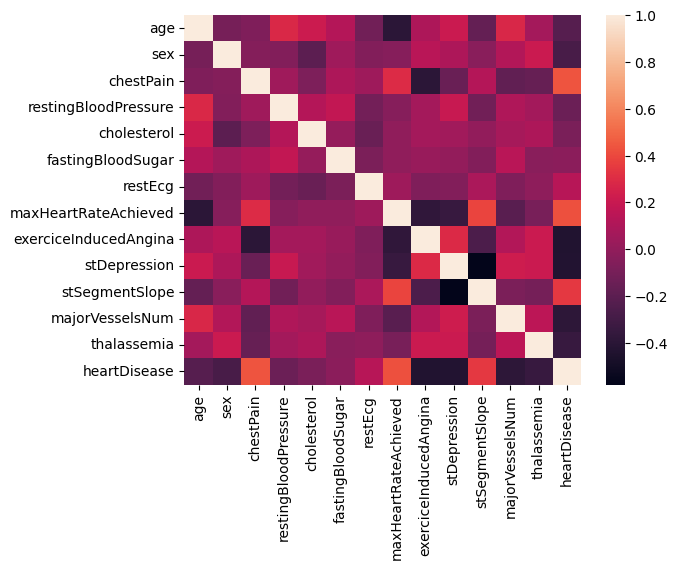

In [267]:
corr = renamedHeartDf.corr()
sns.heatmap(corr)

- pegando o nome das colunas com correlação maior que 0.3 e menor que 1 em
relação a chance de ataque cardíaco.

In [268]:
allCorr = corr.heartDisease[(corr.heartDisease.abs() > 0.3) & (corr.heartDisease.abs() < 1)].index
positiveCorr = corr.heartDisease[(corr.heartDisease > 0.3) & (corr.heartDisease.abs() < 1)].index
negativeCorr = corr.heartDisease[corr.heartDisease < -0.3].index
print(allCorr)
print(positiveCorr)
print(negativeCorr)

Index(['chestPain', 'maxHeartRateAchieved', 'exerciceInducedAngina',
       'stDepression', 'stSegmentSlope', 'majorVesselsNum', 'thalassemia'],
      dtype='object')
Index(['chestPain', 'maxHeartRateAchieved', 'stSegmentSlope'], dtype='object')
Index(['exerciceInducedAngina', 'stDepression', 'majorVesselsNum',
       'thalassemia'],
      dtype='object')


- preparação dos conjuntos de dados para teste

In [269]:
targetResults = renamedHeartDf.heartDisease
renamedHeartDf.drop("heartDisease", axis=1, inplace=True)

dataMap = {
  "allDataDf": [],
  "allCorrDf": allCorr,
  "positiveCorrDf": positiveCorr,
  "negativeCorrDf": negativeCorr,
}

def filterData(df, columns):
  if len(columns) == 0: return df
  else: return df[columns]

- Testando a acurácia dos modelos de árvore de decisão com conjuntos de dados
com colunas diferentes

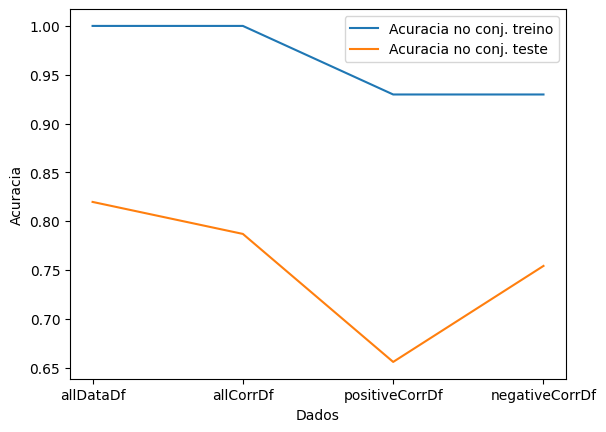

In [270]:
training_accuracy = []
test_accuracy = []

data_train, data_test, results_train, results_test = train_test_split(
  renamedHeartDf, 
  targetResults,
  test_size=0.2
)

for data in dataMap:
  tree = DecisionTreeClassifier()
  tree.fit(filterData(data_train, dataMap[data]),results_train)
  training_accuracy.append(tree.score(filterData(data_train, dataMap[data]),results_train))
  test_accuracy.append(tree.score(filterData(data_test, dataMap[data]), results_test))

plt.plot(dataMap.keys(),training_accuracy, label='Acuracia no conj. treino')
plt.plot(dataMap.keys(),test_accuracy, label='Acuracia no conj. teste')
plt.ylabel('Acuracia')
plt.xlabel('Dados')
plt.legend()

- Refazendo o teste 100 vezes para garantir a escolha do melhor conjunto de colunas
do dados utilizados no treinamento do modelo

In [271]:
file = open('./output.csv', 'a')
file.write('df,train_score,test_score\n')

for i in range(0, 100):
  data_train, data_test, results_train, results_test = train_test_split(
    renamedHeartDf, 
    targetResults,
    test_size=0.2
  )

  for data in dataMap:
    tree = DecisionTreeClassifier()
    tree.fit(filterData(data_train, dataMap[data]),results_train)
    train_score = tree.score(filterData(data_train, dataMap[data]),results_train)
    test_score = tree.score(filterData(data_test, dataMap[data]), results_test)
    file.write("%s,%.2f,%.2f\n" % (data, train_score,test_score))

file.close()

In [272]:
resultsDf = pd.read_csv('./output.csv')

In [273]:
resultsDf.head()

,df,train_score,test_score
0,allDataDf,1.00,0.75
1,allCorrDf,1.00,0.75
2,positiveCorrDf,0.95,0.64
3,negativeCorrDf,0.93,0.79
4,allDataDf,1.00,0.82


In [274]:
resultsDf.groupby('df').test_score.agg([min, max, 'mean'])

,min,max,mean
df,,,
allCorrDf,0.62,0.87,0.7575
allDataDf,0.62,0.89,0.7583
negativeCorrDf,0.62,0.89,0.7355
positiveCorrDf,0.52,0.84,0.6801


Visto que, não existem grandes diferenças entre utilizar colunas com correlações maiores
com a chance de ataque cardíaco ou não, serão utilizados todos os dados de todas as colunas
para garantir que os dados sejam mais completos e as decisões mais precisas.

In [275]:
model = DecisionTreeClassifier()
model.fit(data_train, results_train)
score = model.score(data_test, results_test)

print("Precisão: %.2f" % score)

Precisão: 0.82


In [370]:
data_train, data_test, results_train, results_test = train_test_split(
  renamedHeartDf, 
  targetResults,
  test_size=0.2
)

,criteria,training_accuracy,test_accuracy
0,gini,1.0,0.754098
1,entropy,1.0,0.786885
2,log_loss,1.0,0.770492


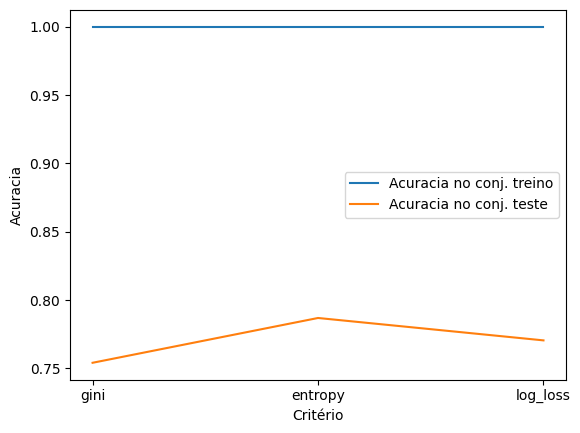

In [380]:
training_accuracy = []
test_accuracy = []

criteria = ["gini", "entropy", "log_loss"]

for criterion in criteria:
  tree = DecisionTreeClassifier(criterion=criterion)
  tree.fit(data_train,results_train)
  training_accuracy.append(tree.score(data_train, results_train))
  test_accuracy.append(tree.score(data_test, results_test))

plt.plot(criteria,training_accuracy, label='Acuracia no conj. treino')
plt.plot(criteria,test_accuracy, label='Acuracia no conj. teste')
plt.ylabel('Acuracia')
plt.xlabel('Critério')
plt.legend()

pd.DataFrame({"criteria": criteria, "training_accuracy": training_accuracy, "test_accuracy":test_accuracy })

,splitter,training_accuracy,test_accuracy
0,best,1.0,0.786885
1,random,1.0,0.704918


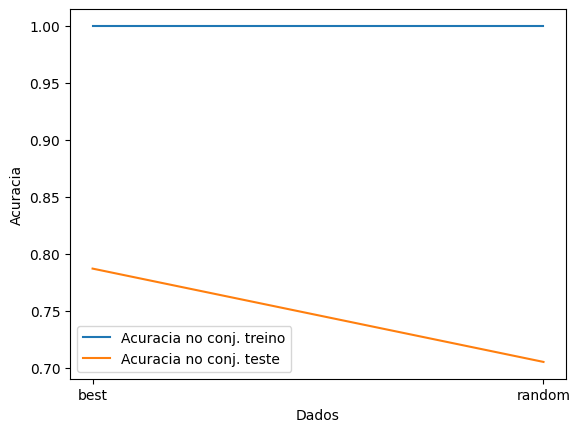

In [379]:
training_accuracy = []
test_accuracy = []

splitter = ["best", "random"]

for split in splitter:
  tree = DecisionTreeClassifier(criterion="entropy", splitter=split)
  tree.fit(data_train,results_train)
  training_accuracy.append(tree.score(data_train, results_train))
  test_accuracy.append(tree.score(data_test, results_test))

plt.plot(splitter, training_accuracy, label='Acuracia no conj. treino')
plt.plot(splitter, test_accuracy, label='Acuracia no conj. teste')
plt.ylabel('Acuracia')
plt.xlabel('Dados')
plt.legend()

pd.DataFrame({"splitter": splitter, "training_accuracy": training_accuracy, "test_accuracy":test_accuracy })

,max_depth,training_accuracy,test_accuracy
0,1,0.768595,0.721311
1,2,0.780992,0.622951
2,3,0.851240,0.803279
3,4,0.863636,0.803279
4,5,0.921488,0.786885
5,6,0.958678,0.754098
6,7,0.987603,0.754098
7,8,0.991736,0.786885
8,9,0.995868,0.770492


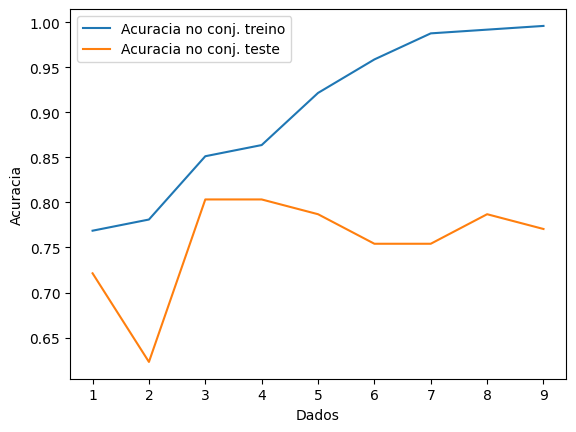

In [387]:
training_accuracy = []
test_accuracy = []

max_depth= range(1, 10)

for depth in max_depth:
  tree = DecisionTreeClassifier(criterion="entropy", max_depth=depth, splitter="best")
  tree.fit(data_train,results_train)
  training_accuracy.append(tree.score(data_train, results_train))
  test_accuracy.append(tree.score(data_test, results_test))

plt.plot(max_depth, training_accuracy, label='Acuracia no conj. treino')
plt.plot(max_depth, test_accuracy, label='Acuracia no conj. teste')
plt.ylabel('Acuracia')
plt.xlabel('Dados')
plt.legend()

pd.DataFrame({"max_depth": max_depth, "training_accuracy": training_accuracy, "test_accuracy":test_accuracy })

In [374]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=3, splitter="best")
model.fit(data_train, results_train)
score = model.score(data_test, results_test)

print("Precisão: %.2f" % score)

Precisão: 0.80


In [375]:
test_sample = data_test.head(1)
test_sample

,age,sex,chestPain,restingBloodPressure,cholesterol,fastingBloodSugar,restEcg,maxHeartRateAchieved,exerciceInducedAngina,stDepression,stSegmentSlope,majorVesselsNum,thalassemia
136,60,0,2,120,178,1,1,96,0,0.0,2,0,2


In [376]:
result_test_sample = results_test.head(1)
result_test_sample

136    1
Name: heartDisease, dtype: int64

In [377]:
model.predict(test_sample)

array([1])

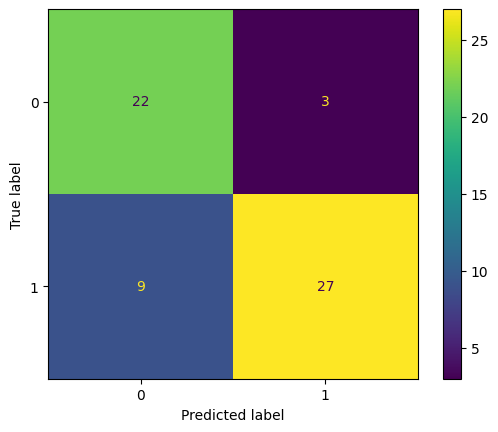

In [388]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = model.predict(data_test)

cm = confusion_matrix(results_test, preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()